# Ejercicio 1


#TODO: hacer manual el calculo del periodograma

In [62]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.signal
from scipy.signal import lfilter, periodogram, freqz, correlate
import soundfile as sf
from scipy.fft import fft
from scipy.signal import freqz, lfilter, butter
import sounddevice as sd

In [63]:
# Coeficiente b
coef_b = {'a':[0.0311], 'e':[0.0321],'i':[0.0121], 'o':[0.0073], 'u': [0.00258], 's':[0.0251], 'sh':[0.0302], 'f':[0.0453], 'j':[0.0245]}

# Coeficientes ai
coef_a = {
        "a":[1.1835, -0.5685, 0.3874, 0.2939, -0.9807, 0.587, -0.2441, -0.0866, 0.4763, -0.0491, -0.1137, 0.0601, -0.4138, 0.2613, 0.1998, -0.0327, 0.0894, -0.195, -0.0695, 0.01],
        "e":[0.3876, -0.8134, 1.126, 0.3371, 0.7794, 0.413, -0.6026, -0.4977, -0.9342, -0.3311, -0.0233, 0.3248, 0.388, 0.4025, 0.0977, -0.0062, -0.0465, -0.1614, -0.0132, -0.1101],
        "i":[-0.2189, -0.6421, 1.3317, 1.3899, 1.6527, 0.3503, -1.0505, -1.8235, -1.6228, -0.5322, 0.3435, 0.9051, 0.7906, 0.3556, 0.2841, -0.164, 0.084, -0.2809, -0.0976, -0.1635],
        "o":[1.2328, -0.6982, 1.4335, -0.4589, 0.3123, -1.1168, -0.6169, -0.1906, 0.5552, 0.5243, 0.8605, -0.0488, -0.3003, -0.855, -0.1109, -0.0894, 0.5002, 0.0034, 0.3986, -0.386],
        "u":[0.735, 0.3731, 0.5123, 1.0994, -1.1137, -1.1504, -0.3682, -0.3828, 0.7703, 0.8673, 0.2769, -0.198, -0.1659, -0.3783, -0.1847, 0.1825, 0.1184, -0.0033, 0.1232, -0.1316],
        "s":[-0.3646, 0.1339, -0.0423, -0.1338, 0.1461, 0.0452, 0.2571, 0.2483, 0.055, 0.0955, 0.265, 0.204, -0.0319, -0.1486, 0.0459, 0.0725, 0.1031, -0.0649, -0.0051, 0.0186],
        "sh":[1.0213, -1.6453, 0.9882, -1.4537, 0.9707, -1.0667, 0.9042, -0.7057, 0.8852, -0.5809, 0.7712, -0.3084, 0.4782, -0.3091, 0.4741, -0.3427, 0.3427, -0.2138, 0.0853, -0.0054],
        "f":[0.5988, -0.0429, -0.3181, -0.2044, 0.3401, -0.2233, -0.0889, 0.1002, 0.0213, -0.0634, 0.0929, 0.1195, -0.1242, 0.1506, -0.0795, 0.1444, 0.0262, 0.0056, 0.0531, 0.0727],
        "j":[1.1653, -0.6726, 0.67, -0.3186, -0.2648, -0.1825, 0.1804, -0.0515, 0.1982, -0.1682, 0.0735, 0.0452, -0.1658, 0.1665, -0.0253, -0.0508, 0.2067, -0.1849, 0.0751, 0.026]
         }

def gen_pulsos(f0, N, fs):
    """
    Genera un tren de impulsos periodico en el tiempo.
    f0: frecuencia fundamental (pitch) del tren de impulsos [Hz].
    N: cantidad de puntos que posee el array de la secuencia generada.
    fs: frecuencia de muestreo [Hz].
    Retorna: tren de impulsos (con varianza normalizada) de frecuencia f0.
    """
    s = np.zeros(N)
    s[np.arange(N) % round(fs / f0) == 0] = np.sqrt(fs / f0)
    return s

def psd_pulsos(f0, N, fs):
    """
    Genera la densidad espectral de potencia de un tren de impulsos.
    f0: frecuencia fundamental [Hz] (pitch) del tren de impulsos en el tiempo.
    N: cantidad de puntos que posee el array de la PSD resultante (SU(w)).
    fs: frecuencia de muestreo [Hz].
    Retorna:
    - PSD del tren de impulsos
    - Vector de frecuencias del espectro [Hz]
    """
    u = gen_pulsos(f0, N, fs)
    f = np.arange(N) * fs /N    # Vector de frecuencias (Hz)
    Su = np.abs(fft(u))**2 / N  # Periodograma
    return Su, f

def suavizar_bordes(x, fade=20):
    """
    Suaviza los bordes de una señal.
    x: señal original (array).
    fade: (float) porcentaje de transición en los bordes (0-50% del largo de x)
    retorna: versión suavizada de x
    """
    N = len(x)
    fade = max(1, min(fade, 50))  # Limita fade entre 1 y 50
    M = 2 * int(fade / 100 * N)
    v = np.hamming(M)
    fade_in = v[:M // 2]
    fade_out = v[M // 2:]
    window = np.concatenate([fade_in, np.ones(N - M), fade_out])
    s = window * x
    return s

def reproducir(audio, fs):
    """
    Reproducir audio usando soundevice
    audio: array con el contenido de la señal
    fs: freucencia de muestreo [Hz]
    """
    sd.play(audio, fs)
    sd.wait()

def densidadEspectralPotenciaAR(coef_a: np.array, coef_b: float, frecuencias: np.array,
                               S_U: np.array, fs: int) -> np.array:
    """
    Calcula la PSD de la salida de un proceso AR (AutoRegresivo)
    
    Parámetros:
    - coef_a: array con coeficientes AR [a1, a2, ..., aP]
    - coef_b: ganancia (escalar)
    - frecuencias: array con frecuencias en Hz
    - S_U: array con PSD de entrada para cada frecuencia
    - fs: frecuencia de muestreo
    
    Retorna:
    - S_X: array con PSD de salida para cada frecuencia 
    """
    omega = 2 * np.pi * frecuencias / fs

    H_f = coef_b / np.abs(1 - np.sum([coef_a[i] * np.exp(-1j * omega * (i + 1)) 
                                      for i in range(len(coef_a))], axis=0))

    # PSD = |H(f)|^2 * S_U
    S_X = np.abs(H_f)**2 * S_U
    return S_X

Se dispone del archivo “data.py” que contiene los diccionarios con los
coeficientes “coef b” y “coef a” del proceso AR (P = 20) que modela cada uno de los audios
provistos.

In [64]:
fs = 14700 
N = int(0.2 * fs) #nos quedamos solo con las muestras q corresponden a los 200ms 

#asumimos procesos estacionarios
colors2 = ['#1D452E', '#3685B5', '#73A580', '#3BA99C', '#7EBCE6']
colors3 = [ "#011936", "#3685B5",  "#3BA99C",  "#109139", "#033312", "#8C1A6A", "#A657AE", "#A71D31", "#804E49"]
colors4 = ["#000100", "#230C33", "#592E83", "#9984D4", "#CAA8F5", "#C32F27", "#D8572A", "#DB7C26", "#F7B538"]
colors44 = ["#C32F27", "#D8572A", "#DB7C26", "#F7B538", "#FFC971", "#8C1A6A", "#A657AE", "#230C33", "#592E83"]
colors=[ "#230C33", "#592E83", "#9984D4", "#A657AE", "#8C1A6A", "#C32F27", "#D8572A", "#DB7C26", "#F7B538"]
"""
FFC971
fríos (azules/ verdes): "#011936", "#465362", "#3685B5", "#9FC490", "#3BA99C",
rosas: "#8C1A6A", "#A657AE", "#A71D31", "#804E49"
"""
audios_vocales = ['a.wav', 'e.wav', 'i.wav', 'o.wav', 'u.wav']
audios_consonantes = ['f.wav', 's.wav', 'j.wav', 'sh.wav']

fonemas = ['a', 'e', 'i', 'o', 'u', 'sh', 'f', 's', 'j']



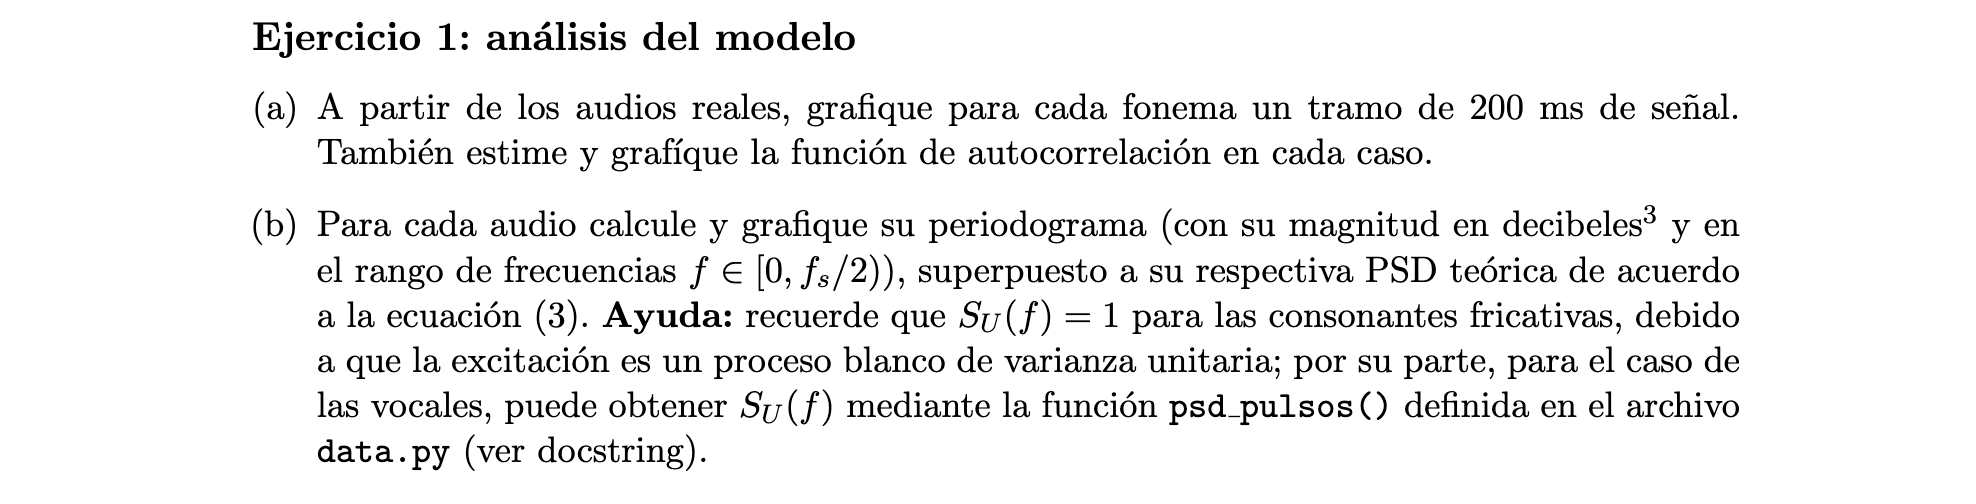

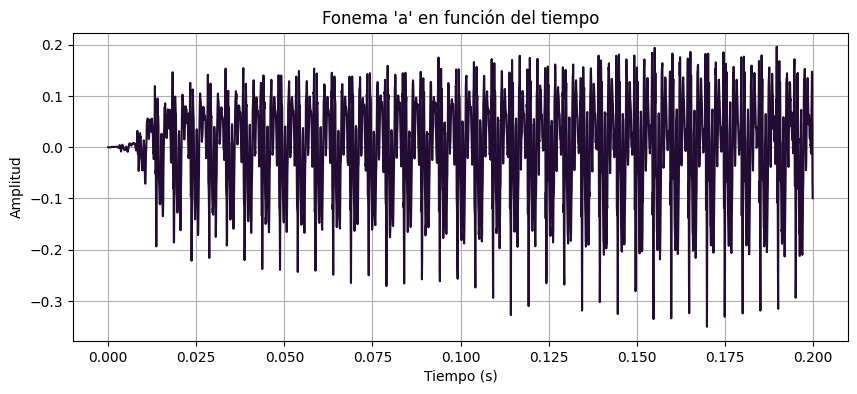

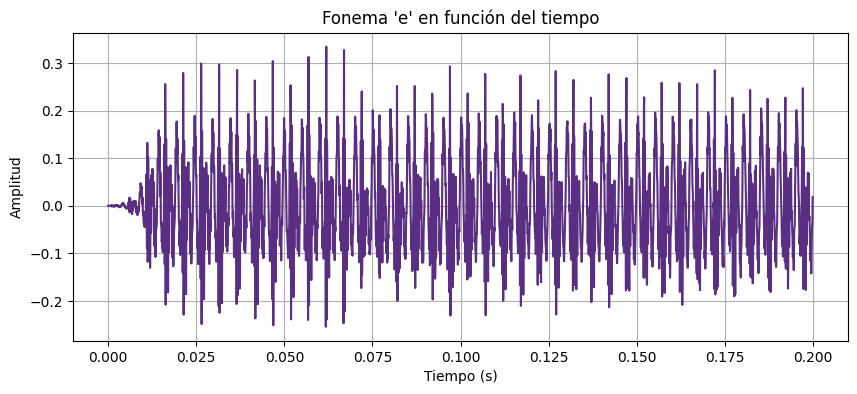

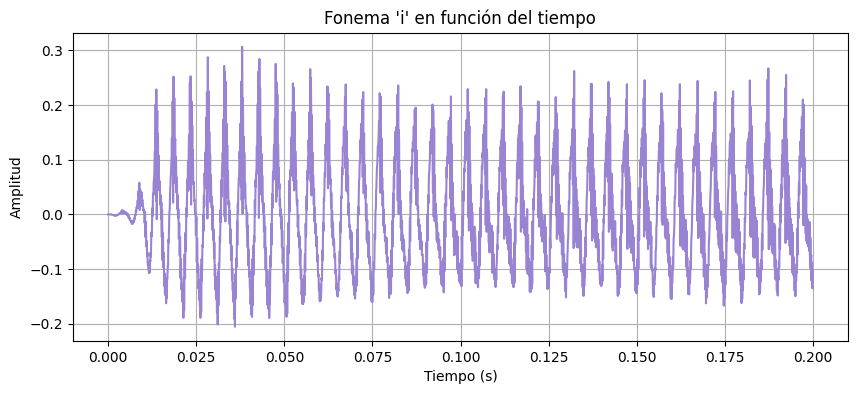

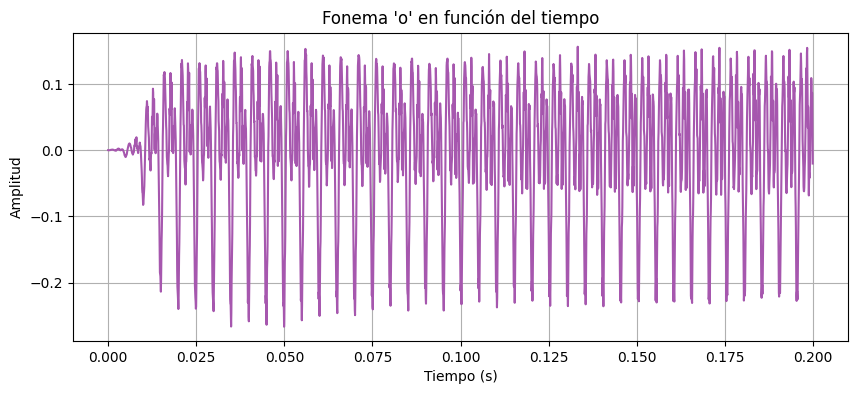

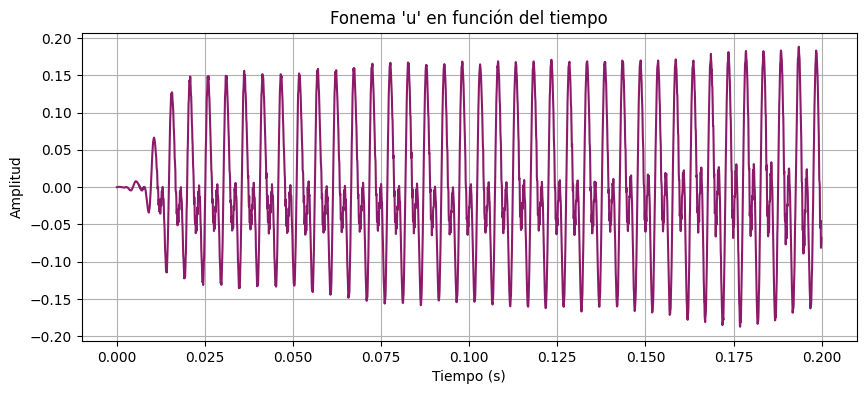

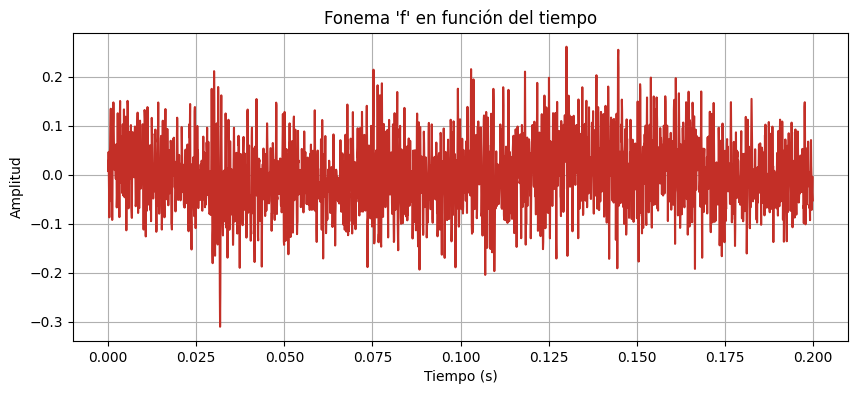

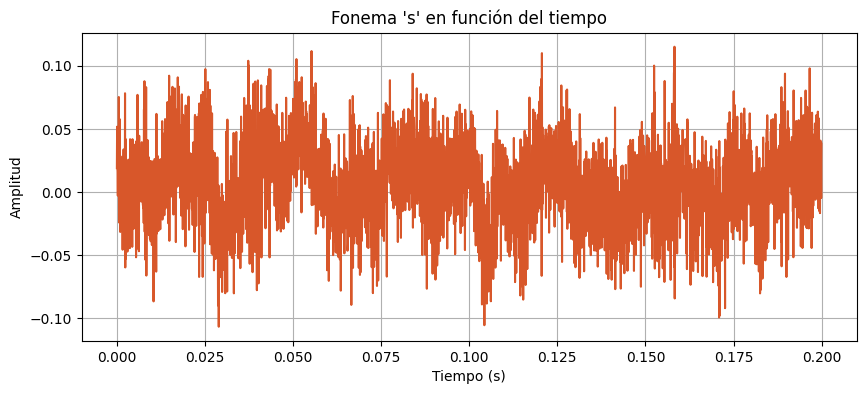

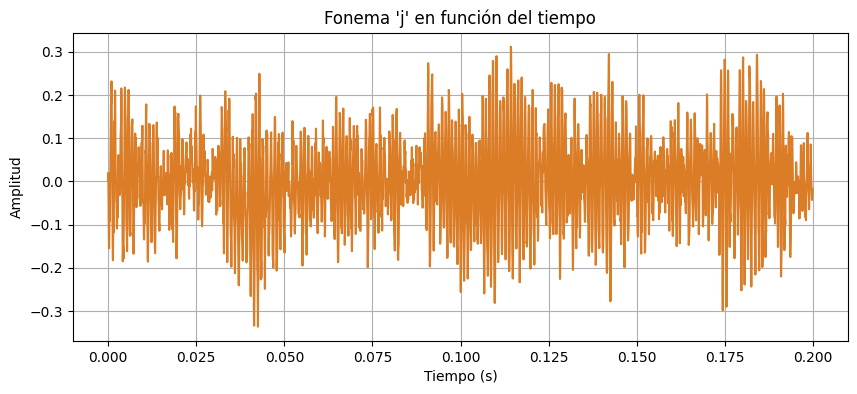

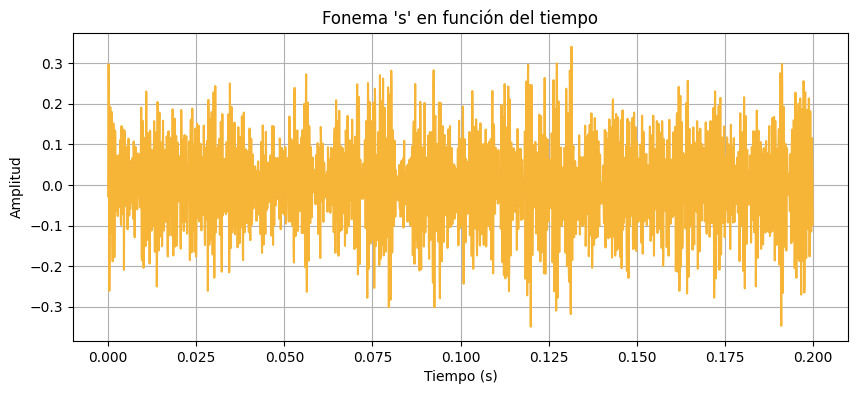

In [65]:
#a) graficar fonemas
tramos = [] 
audios = []
fss = []
for idx,i in enumerate(audios_vocales + audios_consonantes):
    audio, _ = sf.read(i)
    audios.append(audio)
    fss.append(_)

    tramo = audio[:N] # tomamos solo los primeros 200ms
    tramos.append(tramo)
    time = np.arange(len(audio)) / fs

    plt.figure(figsize=(10, 4))

    plt.plot(time[:N], tramo, colors[idx % len(colors)])
    plt.title(f"Fonema '{i[0]}' en función del tiempo")
    plt.xlabel("Tiempo (s)")
    plt.ylabel("Amplitud")
    plt.grid()
    plt.show()


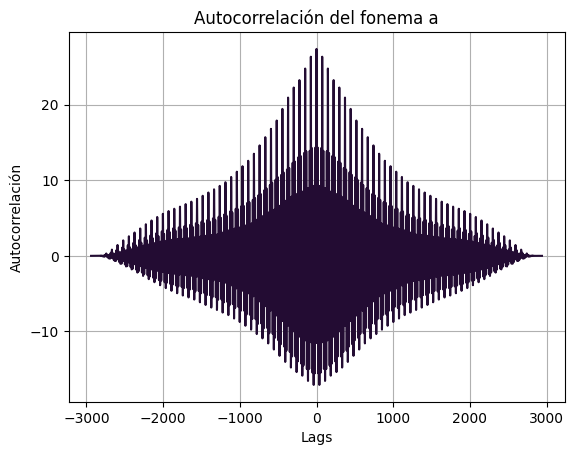

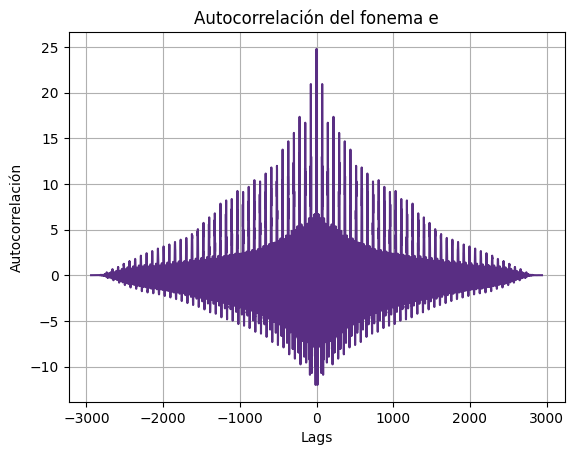

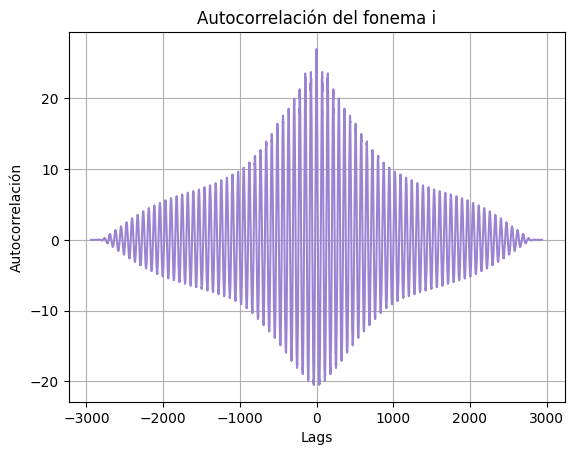

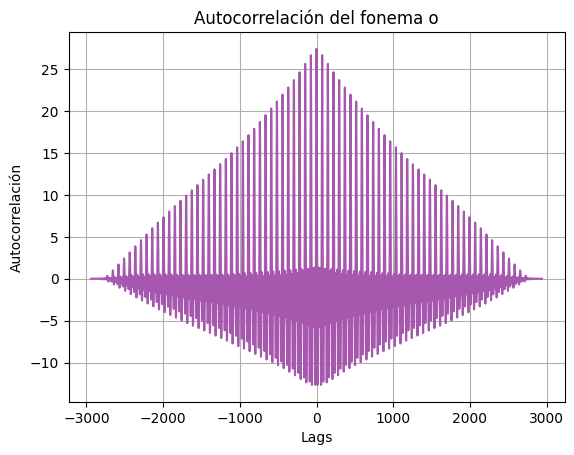

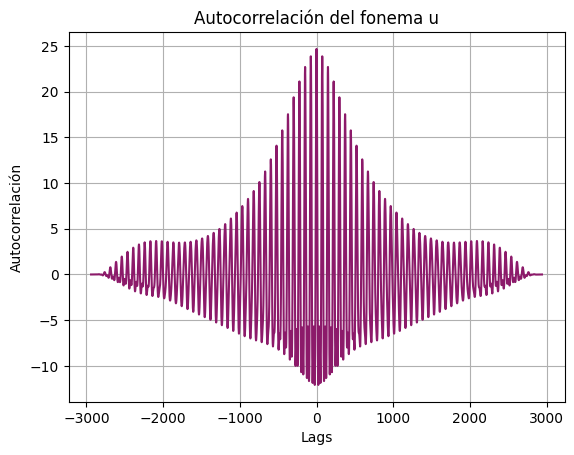

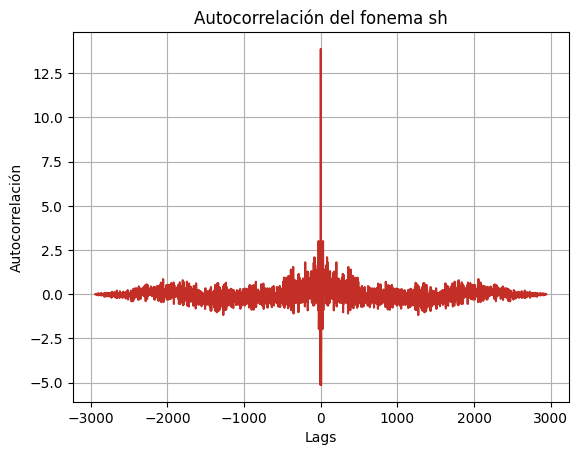

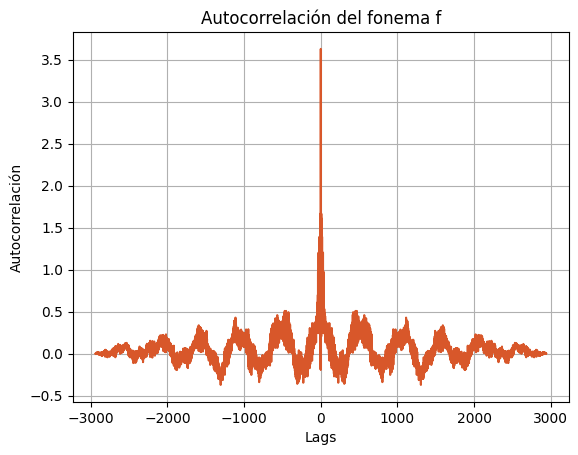

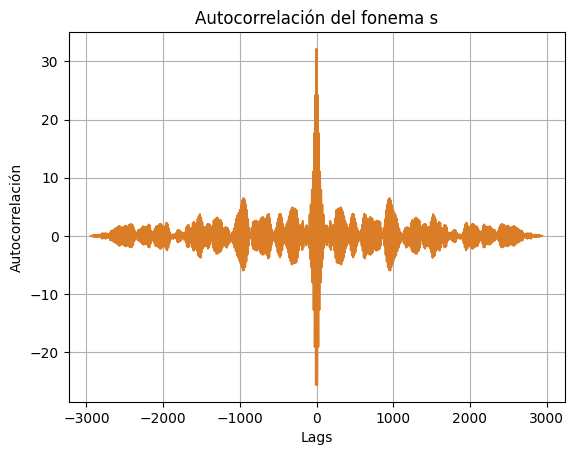

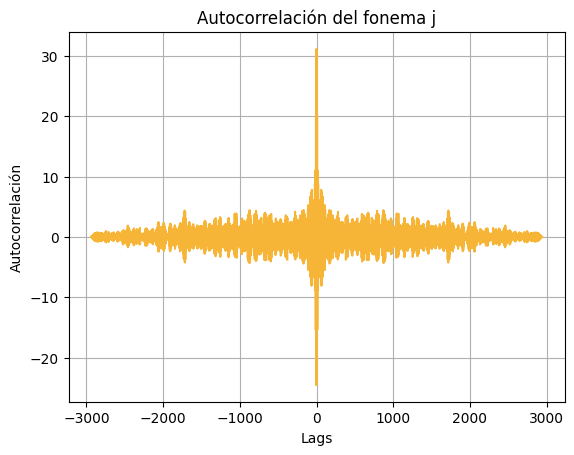

In [66]:
#a) estimar + graficar autocorr

def graficar_autocorrelacion(tramo, fonema, color):
    autocorrelacion = correlate(tramo, tramo, mode='full')
    lags = np.arange(-len(tramo) + 1, len(tramo))
    plt.plot(lags, autocorrelacion, color)
    plt.title(f"Autocorrelación del fonema {fonema}")
    plt.xlabel("Lags")
    plt.ylabel("Autocorrelación")
    plt.grid()
    plt.show()


for i in range(len(fonemas)):
    graficar_autocorrelacion(tramos[i], fonemas[i], colors[i % len(colors)])


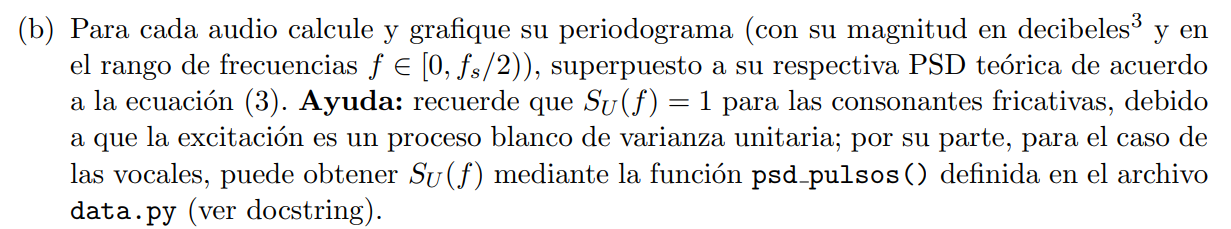

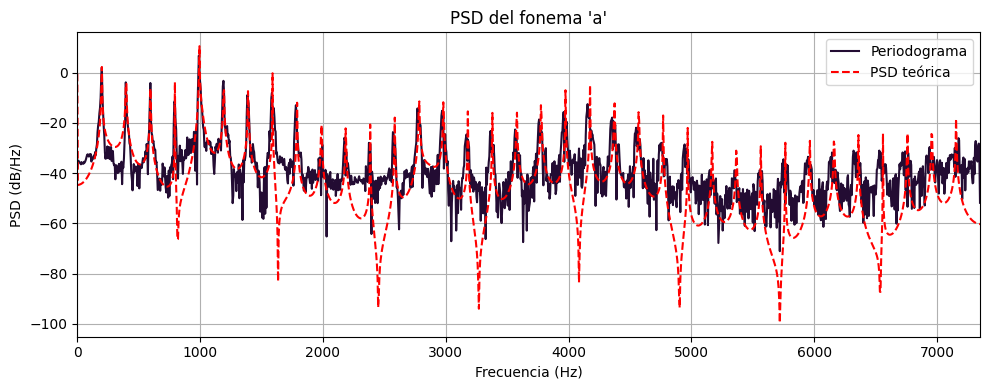

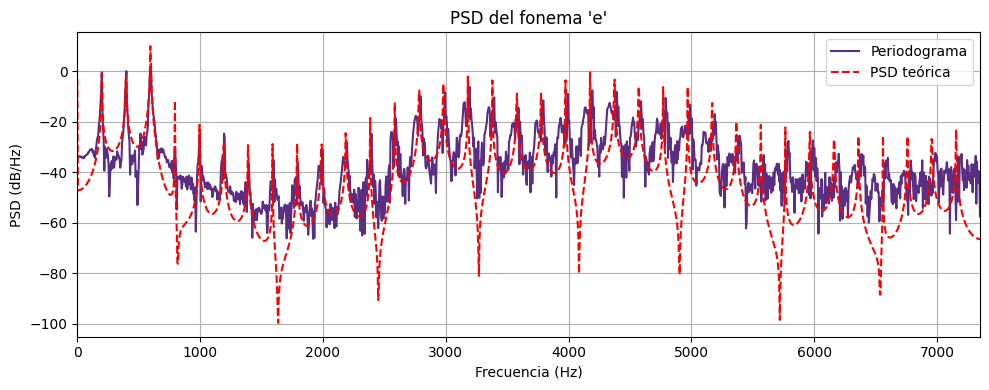

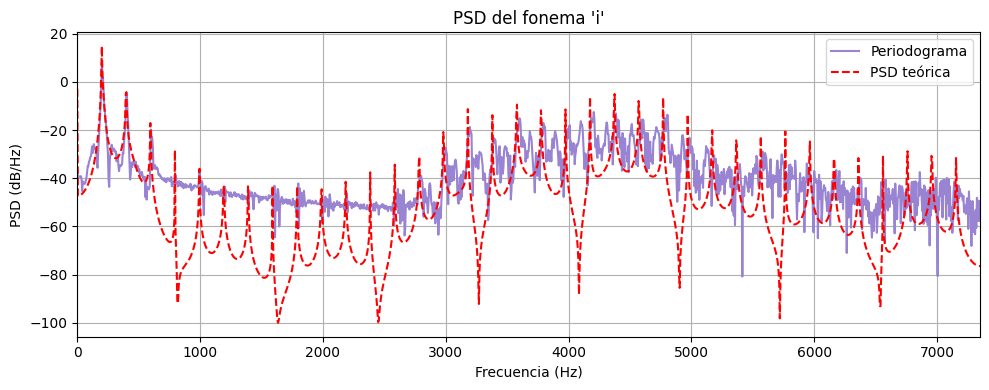

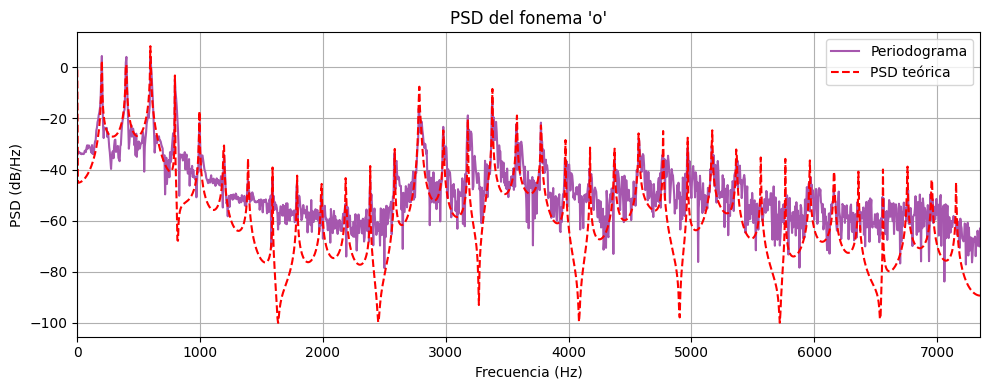

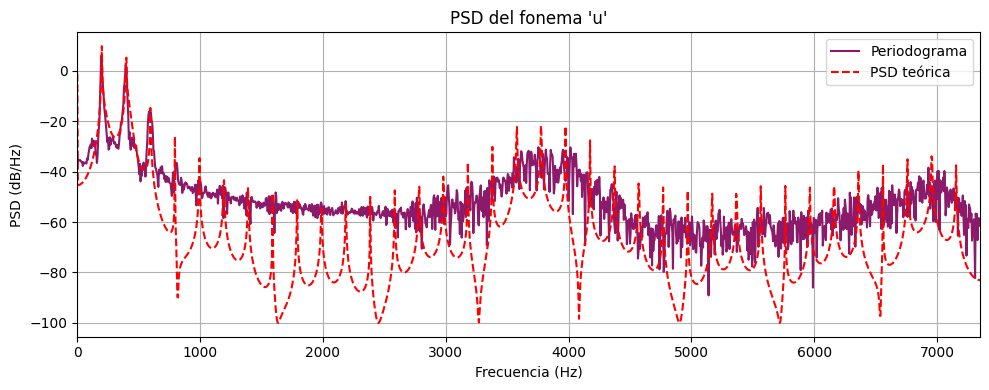

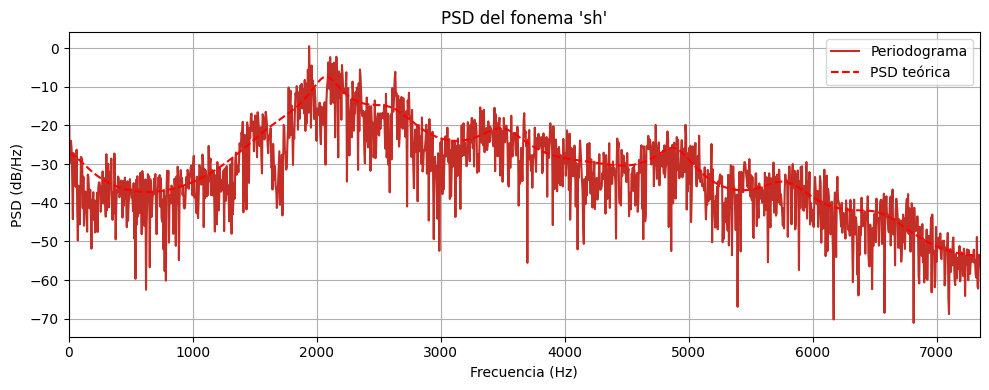

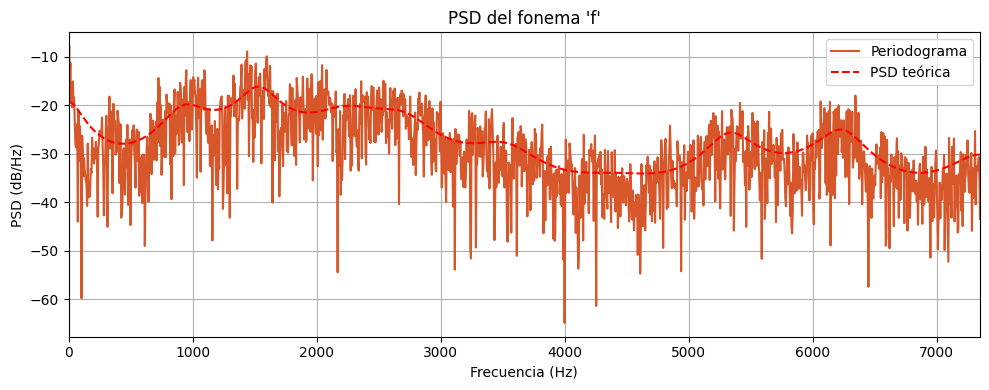

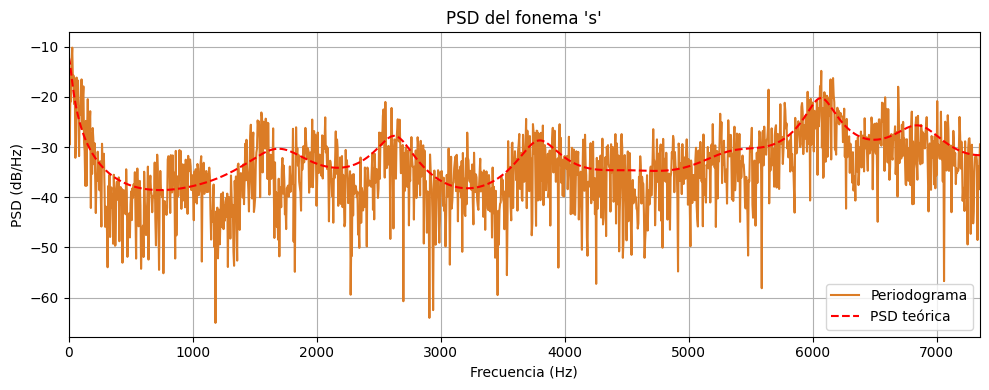

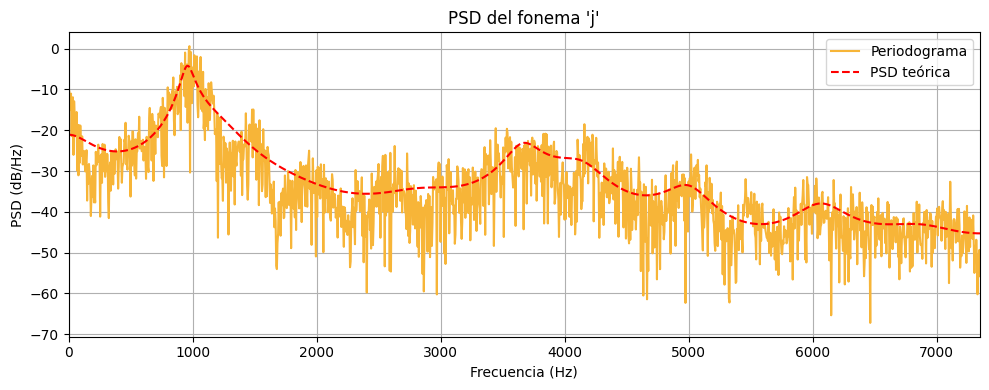

In [67]:
fs = 14700
N_200ms = int(0.2 * fs)
N_500ms = int(0.5 * fs)

vocales = ['a', 'e', 'i', 'o', 'u']
consonantes = ['sh', 'f', 's', 'j']
fonemas = vocales + consonantes

audios_vocales = ['a.wav', 'e.wav', 'i.wav', 'o.wav', 'u.wav']
audios_consonantes = ['sh.wav', 'f.wav', 's.wav', 'j.wav']
todos_audios = audios_vocales + audios_consonantes

def calcular_y_graficar_psd(tramo, fonema, color, fs=14700):
    """Calcula y grafica el periodograma y la PSD teórica de un fonema"""
    N_tramo = len(tramo)
    
    #Periodograma
    X = fft(tramo)
    n_half = N_tramo//2 + 1
    Pxx = (np.abs(X[:n_half])**2) / N_tramo
    f = np.linspace(0, fs/2, n_half)
    
    plt.figure(figsize=(10, 4))
    plt.plot(f, 10 * np.log10(Pxx + 1e-10), label="Periodograma", color=color)
    
    coef_a_fonema = np.array(coef_a[fonema])
    coef_b_fonema = coef_b[fonema][0]
    
    if fonema in consonantes:
        S_U = np.ones_like(f)
    else:
        f0 = 200
        Su, f_pulsos = psd_pulsos(f0, len(f) * 2, fs)
        S_U = Su[:len(f)]
    
    #PSD teórica
    S_X_teorica = densidadEspectralPotenciaAR(coef_a_fonema, coef_b_fonema, f, S_U, fs)
    
    plt.plot(f, 10 * np.log10(S_X_teorica + 1e-10), 'r--', label="PSD teórica")
    plt.title(f"PSD del fonema '{fonema}'")
    plt.xlabel("Frecuencia (Hz)")
    plt.ylabel("PSD (dB/Hz)")
    plt.legend()
    plt.grid(True)
    plt.xlim(0, fs/2)
    plt.tight_layout()
    plt.show()

audios = []
tramos = []

for i, archivo in enumerate(todos_audios):
    audio, _ = sf.read(archivo)
    audios.append(audio)
    tramo = audio[:N_200ms] #primeros 200ms
    tramos.append(tramo)    
    calcular_y_graficar_psd(tramo, fonemas[i], colors[i % len(colors)], fs=fss[i])
        

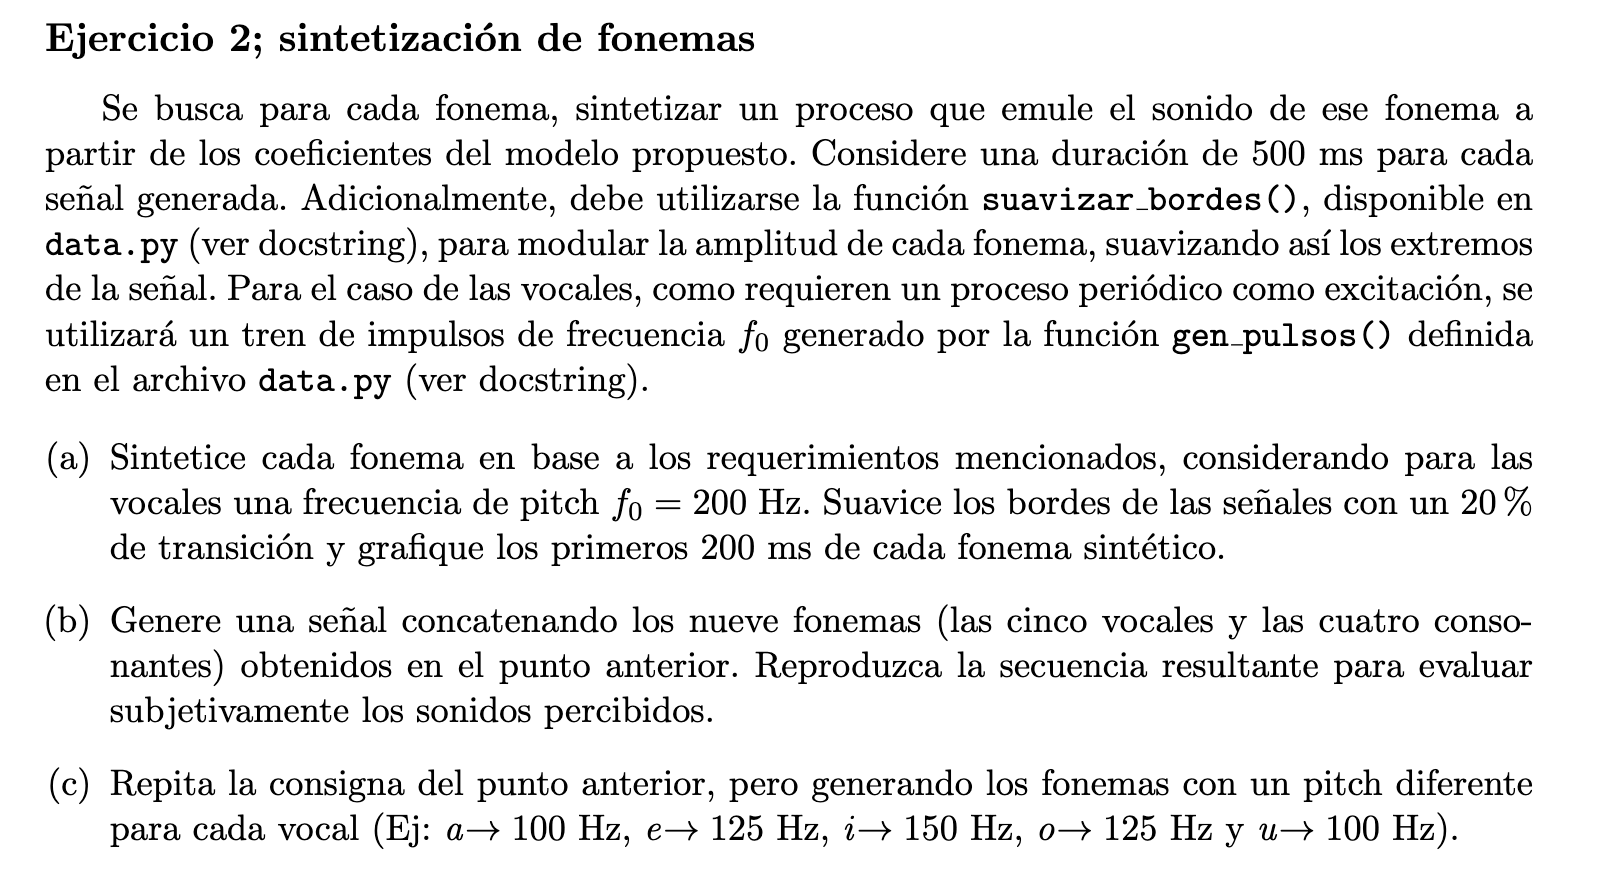

In [68]:
#lo que queremos "copiar"
for i in audios:
    reproducir(i, fs)

duracion_fonema = 0.5
N = int(duracion_fonema * fs) #piso val
f0_vocales = 200

print(fonemas[:5])

['a', 'e', 'i', 'o', 'u']


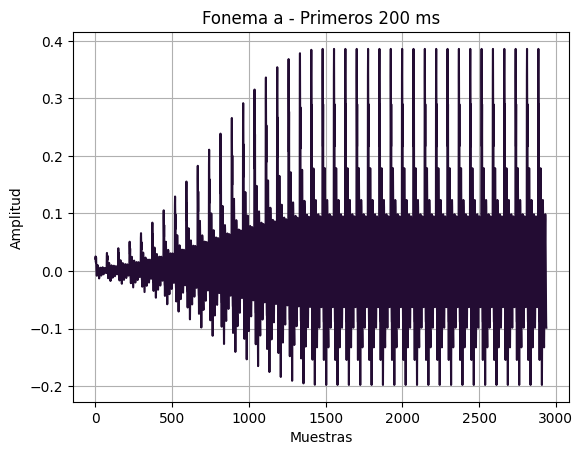

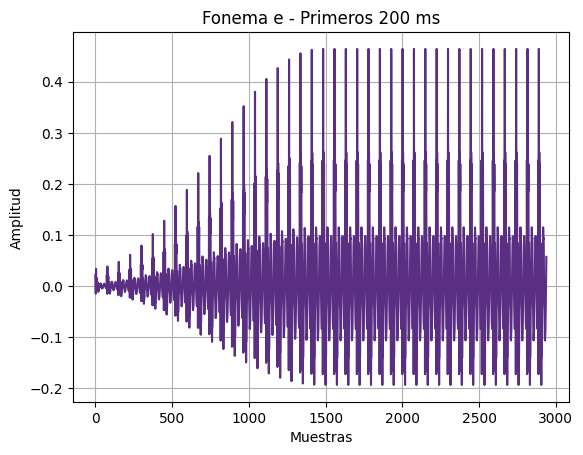

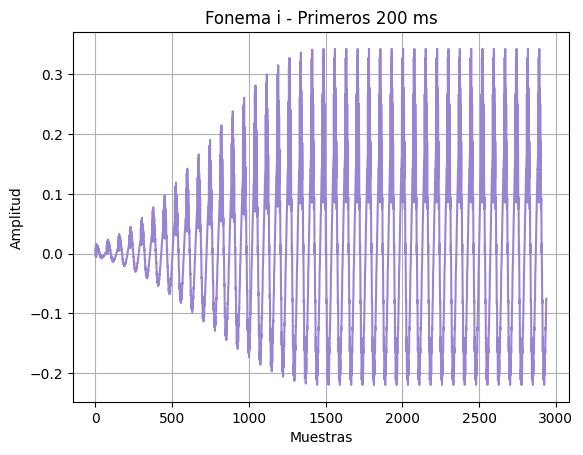

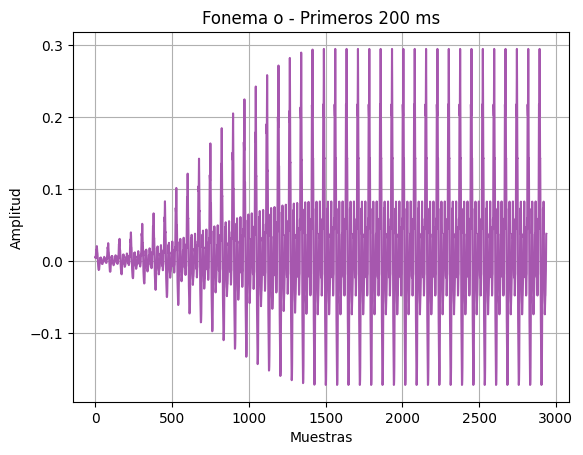

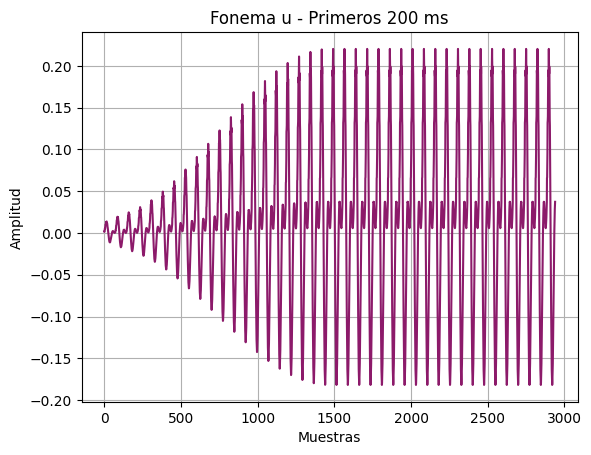

In [69]:
#a)
señales_fonemas = {}
f0_vocales = 200

for i, fonema in enumerate(fonemas):  # TODOS los fonemas
    if fonema in ['f', 's', 'j', 'sh']:
        excitacion = np.random.randn(N)  # para las consonantes usamos ruido blanco
    else:
        excitacion = gen_pulsos(f0_vocales, N, fs) # para las vocales usamos tren de pulsos
    
    b = np.array(coef_b[fonema])
    a = np.array([1.0] + [-coef for coef in coef_a[fonema]])
    
    señal = lfilter(b, a, excitacion)
    señal = suavizar_bordes(señal)
    señales_fonemas[fonema] = señal
    
    if i < 5:
        plt.figure()
        plt.plot(señal[:int(0.2 * fs)], color=colors[i])
        plt.title(f"Fonema {fonema} - Primeros 200 ms")
        plt.xlabel("Muestras")
        plt.ylabel("Amplitud")
        plt.grid()
        plt.show()

In [70]:
señales_ordenadas = [señales_fonemas[fonema] for fonema in fonemas]
señal_concatenada = np.concatenate(señales_ordenadas)
sd.play(señal_concatenada, fs)

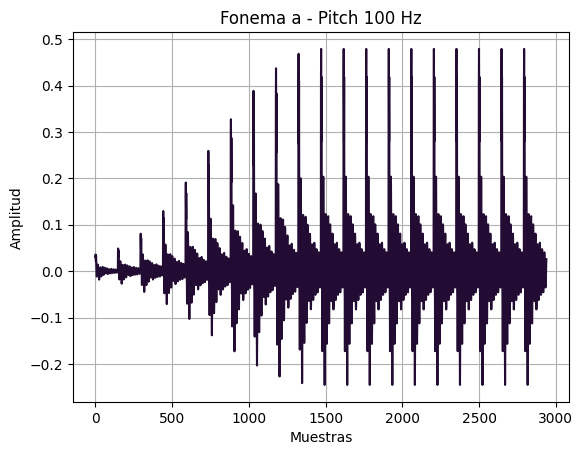

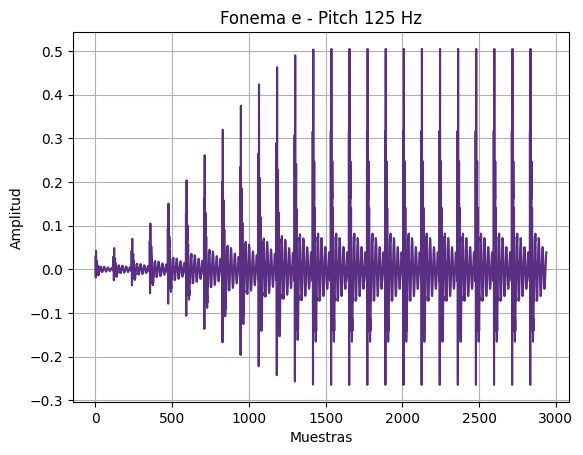

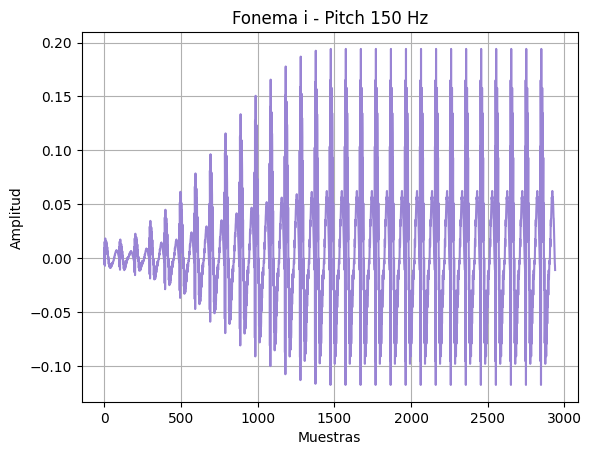

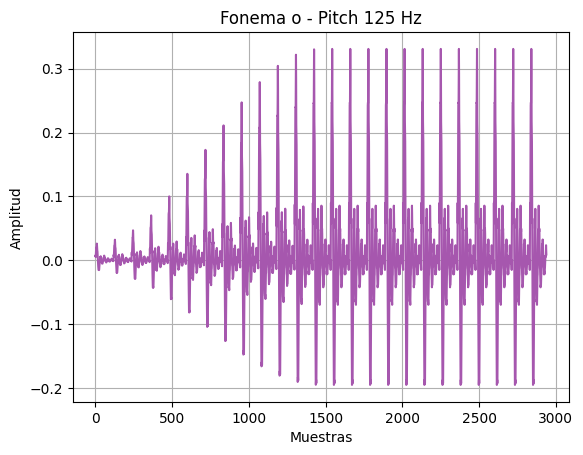

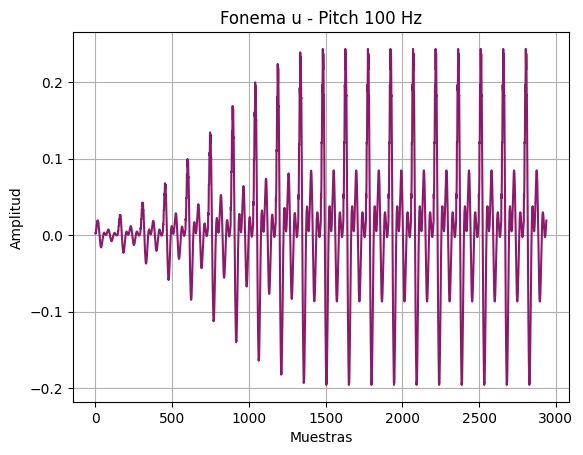

In [71]:
# c) diferentes pitch para cada vocal
pitch_vocales = {
    'a': 100,  
    'e': 125,    
    'i': 150,  
    'o': 125,  
    'u': 100   
}

señales_fonemas_pitch = {}

for i, fonema in enumerate(fonemas):
    if fonema in ['f', 's', 'j', 'sh']:
        excitacion = np.random.randn(N)
    else:
        f0 = pitch_vocales[fonema]  
        excitacion = gen_pulsos(f0, N, fs)
    
    b = np.array(coef_b[fonema])
    a = np.array([1.0] + [-coef for coef in coef_a[fonema]])
    
    señal = lfilter(b, a, excitacion)
    señal = suavizar_bordes(señal)
    señales_fonemas_pitch[fonema] = señal

    if i < 5:
        plt.figure()
        plt.plot(señal[:int(0.2 * fs)], color=colors[i])
        plt.title(f"Fonema {fonema} - Pitch {pitch_vocales.get(fonema, 'N/A')} Hz")
        plt.xlabel("Muestras")
        plt.ylabel("Amplitud")
        plt.grid()
        plt.show()

señales_ordenadas_pitch = [señales_fonemas_pitch[fonema] for fonema in fonemas]
señal_concatenada_pitch = np.concatenate(señales_ordenadas_pitch)
sd.play(señal_concatenada_pitch, fs)